In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Daten Laden

In [3]:

#Daten laden und vorverarbeiten
#Klassen
file_path = "C:\LUH\Master\Masterarbeit\Stereo_camera_program\Daten/info_versuche.xlsx"
klassen = pd.read_excel(file_path)
klassen.rename(columns={'Proben-nummer': 'Proben_nummer'}, inplace=True)
klassen.rename(columns={'Werkzeug-einbau': 'Werkzeug_Einbau'}, inplace=True)
klassen['Proben_nummer'] = klassen['Proben_nummer'].astype(int)

rows_with_nan = klassen[~klassen.isna().any(axis=1)]

#Bildverarbeitungsdaten
file_path = "img_data.xlsx"
# Load the Excel file into a Pandas DataFrame
daten_l = pd.read_excel(file_path,  sheet_name='l')
daten_l.rename(columns={'Unnamed: 0': 'Bild_nummer'}, inplace=True)
daten_l['Bild_nummer']= daten_l['Dateiname'].str.replace('.png', '').astype(int)

daten_r = pd.read_excel(file_path,  sheet_name='l')
daten_r.rename(columns={'Unnamed: 0': 'Bild_nummer'}, inplace=True)
daten_r['Bild_nummer']= daten_r['Dateiname'].str.replace('.png', '').astype(int)

daten= pd.concat([daten_l, daten_r], axis=0)

daten['Position']=-1
daten['Werkzeug_Einbau']=-1

daten['Good_or_bad']='bad'
daten.loc[daten['Bild_nummer'] == 100, 'Good_or_bad'] = 'good'
daten.loc[daten['Bild_nummer'] == 301, 'Good_or_bad'] = 'good'
daten.loc[daten['Bild_nummer'] == 523, 'Good_or_bad'] = 'good'

for i in range(42):
    number= i + 649
    daten.loc[daten['Bild_nummer'] == number, 'Good_or_bad'] = 'good'

rows_with_nan = daten[daten.isna().any(axis=1)]

daten.index = range(1, len(daten) + 1)

index_img= daten['Bild_nummer'].to_numpy()
index_klassen= klassen['Proben_nummer'].to_numpy()

pos=[]
werk=[]
for i in index_img:
    if i in index_klassen:
       pos.append(klassen.loc[klassen['Proben_nummer'] == i, 'Position'].to_numpy()[0]) 
       werk.append(klassen.loc[klassen['Proben_nummer'] == i, 'Werkzeug_Einbau'].to_numpy()[0]) 
    else:
        pos.append('mittig')
        werk.append('korrekt')
daten['Position'] = pos
daten['Werkzeug_Einbau'] = werk
rows_with_nan = daten[daten.isna().any(axis=1)]

#Daten in Quatesierungsstufen anlegen
quant_daten= daten.copy()
quant_daten.loc[quant_daten['Position'] == 'schräg', 'Position']=0
quant_daten.loc[quant_daten['Position'] == 'rechts', 'Position']=50
quant_daten.loc[quant_daten['Position'] == 'mittig', 'Position']=100

quant_daten.loc[quant_daten['Werkzeug_Einbau'] == 'korrekt', 'Werkzeug_Einbau']=0
quant_daten.loc[quant_daten['Werkzeug_Einbau'] == 'falsch', 'Werkzeug_Einbau']=100

quant_daten.loc[quant_daten['Good_or_bad'] == 'bad', 'Good_or_bad']=0
quant_daten.loc[quant_daten['Good_or_bad'] == 'good', 'Good_or_bad']=100

quant_daten = quant_daten.drop(columns=['Dateiname'])
quant_daten.index = range(1, len(quant_daten) + 1)
daten

,Bild_nummer,Dateiname,A,max Grad,min Grad,Var Grad,mittel Grad,median Grad,modus Grad,Rundheit,...,delta FB,delta WB,delta FW,Winkel Weiß zu Max,d1,d2,d3,Position,Werkzeug_Einbau,Good_or_bad
1,1,1.png,7421,115,52.952809,663.759792,80.650936,74.000000,52.952809,0.893585,...,5.099020,34.132096,36.235342,109.184197,0,0,0,schräg,korrekt,bad
2,2,2.png,7265,123,61.660360,642.512327,89.553453,84.000000,61.660360,0.878000,...,15.524175,20.248457,13.601471,134.438295,1,0,0,schräg,korrekt,bad
3,3,3.png,7517,145,57.078893,1310.751401,97.692964,91.000000,57.078893,0.884523,...,12.727922,31.780497,22.090722,115.124264,0,0,0,schräg,korrekt,bad
4,4,4.png,8147,131,64.288413,845.844130,90.429471,76.000000,64.288413,0.876658,...,13.892444,17.000000,29.732137,160.092794,0,0,0,rechts,korrekt,bad
5,5,5.png,7671,136,57.870545,1073.798154,91.623515,81.000000,57.870545,0.879687,...,8.246211,38.587563,33.301652,73.889885,1,0,0,mittig,korrekt,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,686,686.png,19459,126,58.000000,821.057185,86.980512,76.941536,58.000000,0.893621,...,2.000000,0.000000,0.000000,0.000000,1,0,0,mittig,korrekt,good
1375,687,687.png,19539,136,52.000000,1230.681587,88.771158,78.313473,52.000000,0.894640,...,2.236068,0.000000,0.000000,0.000000,1,1,1,mittig,korrekt,good
1376,688,688.png,19213,121,66.000000,545.686578,88.943691,79.831072,66.000000,0.894982,...,1.000000,0.000000,0.000000,0.000000,1,1,1,mittig,korrekt,good
1377,689,689.png,19387,128,34.000000,1474.158296,80.136394,78.409183,34.000000,0.895356,...,3.162278,0.000000,0.000000,0.000000,0,1,1,mittig,korrekt,good


In [4]:
#Daten in Validations und Trainingsdaten aufteilen
from sklearn.model_selection import train_test_split
target = ['Position', 'Werkzeug_Einbau', 'Good_or_bad']
values = ['A', 'max Grad', 'min Grad', 'Var Grad',
          'mittel Grad', 'median Grad', 'modus Grad', 'Rundheit', 'Umfang',
          'Bauteil koor. x', 'Bauteil koor. y', 'Flächenmitte koor. x',
          'Flächenmitte koor. y', 'Weißerstrich koor. x', 'Weißerstrich koor. y',
          'delta FB', 'delta WB', 'delta FW', 'Winkel Weiß zu Max', 'd1', 'd2',
          'd3', ]
X_train, X_val, y_train, y_val = train_test_split(
    quant_daten[values], quant_daten[target], test_size=0.3, random_state=42)



# Daten Standardesierung

In [5]:
from sklearn import preprocessing
#Standartesiere an lernen
scaler = preprocessing.StandardScaler().fit(X_train)

#Trainingsdaten
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)

#Valedierungsdaten
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled,columns=X_val.columns)


# t-SNE

In [6]:
#Daten reduktion trainieren
import seaborn as sns

#Parameter
num_runs = 10
best_cost = np.inf
best_embedding = None

# Ierativ ausprobieren von Anfangszuständen
for i in range(num_runs):
    #MT-sne training
    tsne = TSNE(n_components=2, random_state=i)
    tsne_data = tsne.fit_transform(X_train_scaled)
    cost = tsne.kl_divergence_

    #Vergleich ob Lösung besser nach Verlustfunktion
    if cost < best_cost:
        best_cost = cost
        best_embedding = tsne_data



# Daten in Dtaframe transformieren
tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])

best_cost

0.6116827130317688

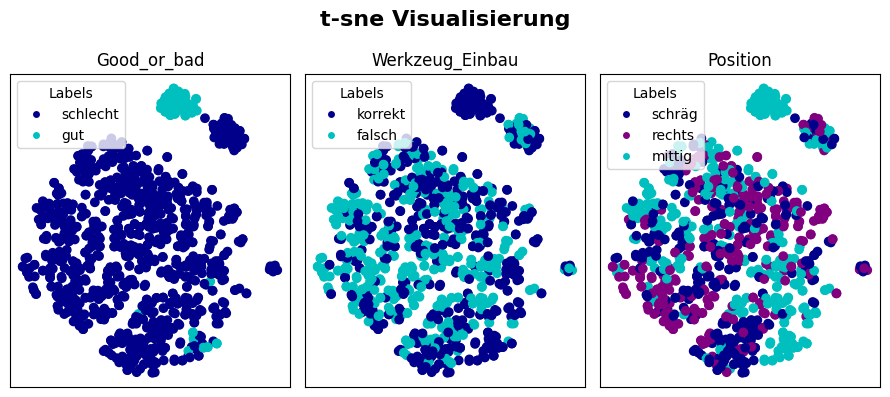

In [7]:
#Visualesierung

#Farben zuweisen
color_themes = ['Good_or_bad', 'Werkzeug_Einbau', 'Position']
labels = [['schlecht', 'gut'], ['korrekt', 'falsch'], ['schräg', 'rechts', 'mittig']]
colors_dict = {
    0: {'schlecht': 'darkblue', 'gut': 'c'},
    1: {'korrekt': 'darkblue', 'falsch': 'c'},
    2: {'schräg': 'darkblue', 'rechts': 'purple', 'mittig': 'c'}
}

# Erstellung gesamt Plot
num_themes = len(color_themes)
fig, axes = plt.subplots(1, num_themes, figsize=(3*num_themes, 4), frameon=True)

# Iteration durch Kategorien
for i, theme in enumerate(color_themes):
    cmap = ListedColormap([colors_dict[i][label] for label in labels[i]])
    ax = axes[i]
    color_variable = y_train[theme]
    scatter = ax.scatter(tsne_df['tsne1'], tsne_df['tsne2'], c=color_variable, cmap=cmap)
    ax.set_xticks([])  
    ax.set_yticks([]) 
    ax.set_title(theme)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in colors_dict[i].items()]
    ax.legend(handles=handles, title="Labels")

fig.suptitle('t-sne Visualisierung', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# PCA

In [7]:
# Standartesierung der Daten
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train_scaled)

# PCA aufführen
pca = PCA()
pca.fit(df_scaled)

# In PCA Koordinaten transformieren
pca_result = pca.transform(df_scaled)

# Varianz der Axen der PCA
explained_variance_ratio = pca.explained_variance_ratio_
print("Varianz der Axen der PCA:", explained_variance_ratio)

Varianz der Axen der PCA: [2.66899652e-01 1.67510613e-01 1.34042625e-01 8.96822927e-02
 7.25810717e-02 4.89863005e-02 4.63932463e-02 4.12446686e-02
 3.57411762e-02 3.24998697e-02 1.86309053e-02 1.67215789e-02
 1.41492967e-02 8.45759630e-03 3.27638832e-03 2.04578074e-03
 6.21478249e-04 3.98820628e-04 7.37318670e-05 4.29068467e-05
 2.76307813e-32 4.01150545e-34]


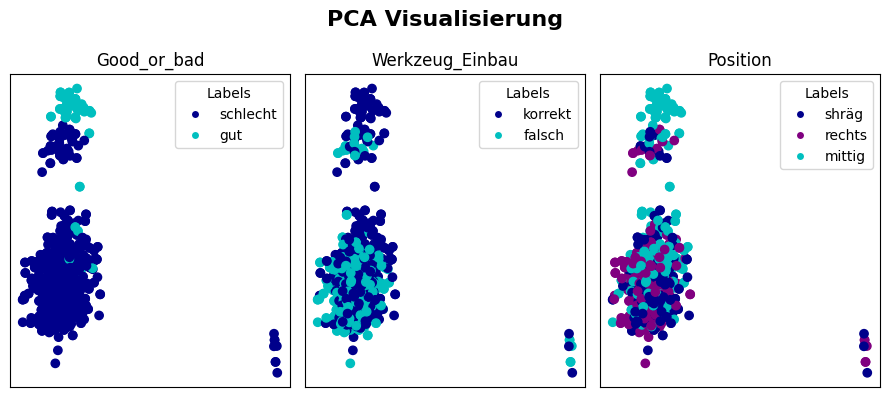

In [8]:
#Auswahl der Axen mitte den zwei größten Eigenwerten
pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(len(X_train_scaled.columns))])

#Farbedefinition
color_themes = ['Good_or_bad', 'Werkzeug_Einbau', 'Position']
labels = [['schlecht', 'gut'], ['korrekt', 'falsch'], ['schräg', 'rechts', 'mittig']]
colors_dict = {
    0: {'schlecht': 'darkblue', 'gut': 'c'},
    1: {'korrekt': 'darkblue', 'falsch': 'c'},
    2: {'schräg': 'darkblue', 'rechts': 'purple', 'mittig': 'c'}
}

# Erstellung der Graphik
num_themes = len(color_themes)
fig, axes = plt.subplots(1, num_themes, figsize=(3*num_themes, 4), frameon=True)

for i, theme in enumerate(color_themes):
    cmap = ListedColormap([colors_dict[i][label] for label in labels[i]])
    ax = axes[i]
    color_variable = y_train[theme]
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], c=color_variable, cmap=cmap)
    ax.set_xticks([])  
    ax.set_yticks([]) 
    ax.set_title(theme)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in colors_dict[i].items()]
    ax.legend(handles=handles, title="Labels")

fig.suptitle('PCA Visualisierung', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Lineare Regression

In [9]:
#Anpassen der Linearen Regression an die Daten
linreg_scaled = LinearRegression()
linreg_scaled.fit(X_train_scaled, y_train)
linreg_scaled.intercept_, linreg_scaled.coef_

(array([51.94255309, 47.37940883,  6.61960137]),
 array([[ 1.80993701e+01,  9.81612514e+14,  3.21086567e+14,
         -9.27910852e+00, -1.79481010e+15,  6.86218196e+14,
          2.91147299e+14,  5.44770370e-02, -1.01218020e+01,
         -5.16901131e+00, -4.60179683e+01, -4.89877861e+00,
          8.44391391e+00,  3.47201469e+01, -2.17486693e+01,
         -1.46196227e+01, -1.79349683e+00, -1.15234375e+01,
         -9.50781250e+00, -6.40625000e-01, -1.87500000e+00,
         -1.50000000e+00],
        [ 9.76289118e+00, -9.77552710e+14, -3.19758600e+14,
         -2.46057978e+01,  1.78738703e+15, -6.83380099e+14,
         -2.89943157e+14, -3.47617853e-02, -1.38619064e+01,
         -6.60258396e+00, -4.29554077e+01,  1.45288158e+01,
          2.86288751e+00,  1.70998919e+01, -1.41853246e+01,
          1.14709733e+01,  8.53958839e+00,  1.42187500e+00,
         -4.64843750e+00,  1.87500000e-01,  5.75000000e+00,
         -6.12500000e+00],
        [ 1.14956197e+02,  2.44686619e+14,  8.00372707e+1

In [10]:
#Metriken der Linearen Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = linreg_scaled.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

#Ausgabe
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 26.385327384041656
Mean Squared Error: 1145.577183597598
Root Mean Squared Error: 31.427672741061574
R-squared: 0.36937960799536507


c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
#Speichern des lin. Regressionmodells
import pickle

# Save the trained model to a file
with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(linreg_scaled, file)

In [12]:
#Löschen des lin. Regressionmodell
del linreg_scaled

In [13]:
#laden des lin. Regressionsmodell
import pickle

with open('linear_regression_model.pkl', 'rb') as file:
    linreg_scaled = pickle.load(file)

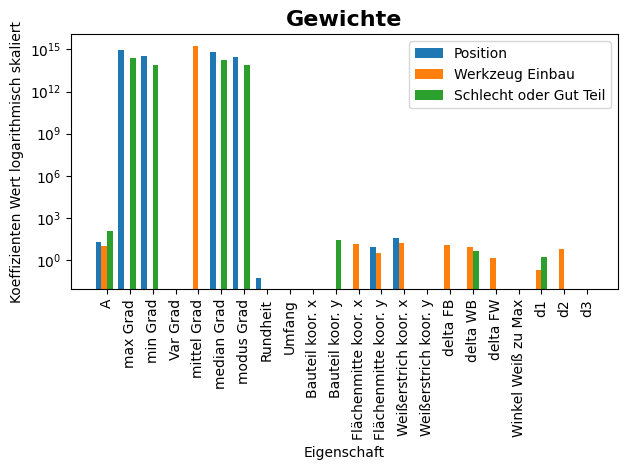

In [14]:
#Einfluss der Gewichte 

feature_names = ['A', 'max Grad', 'min Grad', 'Var Grad',
          'mittel Grad', 'median Grad', 'modus Grad', 'Rundheit', 'Umfang',
          'Bauteil koor. x', 'Bauteil koor. y', 'Flächenmitte koor. x',
          'Flächenmitte koor. y', 'Weißerstrich koor. x', 'Weißerstrich koor. y',
          'delta FB', 'delta WB', 'delta FW', 'Winkel Weiß zu Max', 'd1', 'd2',
          'd3', ]

labels=['Position', 'Werkzeug Einbau', 'Schlecht oder Gut Teil']

def create_2d_bar_chart(data, labels, feature_names):
    num_groups = len(data)
    num_bars = len(data[0])
    
    index = np.arange(num_bars)
    bar_width = 0.25
    
    for i in range(num_groups):
        plt.bar(index + i * bar_width, data[i], bar_width, label=labels[i])

    plt.xlabel('Eigenschaft')
    plt.ylabel('Koeffizienten Wert logarithmisch skaliert')
    plt.title('Gewichte', fontsize=16, fontweight='bold')
    plt.xticks(index + (bar_width * num_groups) / 2, feature_names, rotation=90)
    plt.legend()
    plt.tight_layout()

    plt.yscale('log')

    plt.show()

coef=linreg_scaled.coef_
create_2d_bar_chart(coef, labels, feature_names)


In [15]:
#Transformation der Prediction in Qualitative Eigenschaften
y_lin_pred = linreg_scaled.predict(X_val_scaled)
y_lin_pred[y_lin_pred[:, 0] <= 25, 0] = 0
y_lin_pred[(y_lin_pred[:, 0] > 25) & (y_lin_pred[:, 0] < 75), 0] = 50
y_lin_pred[y_lin_pred[:, 0] >= 75, 0] = 100

y_lin_pred[y_lin_pred[:, 1] < 50, 1] = 0
y_lin_pred[y_lin_pred[:, 1] >= 50, 1] = 100

y_lin_pred[y_lin_pred[:, 2] < 50, 2] = 0
y_lin_pred[y_lin_pred[:, 2] >= 50, 2] = 100

y_lin_pred=y_lin_pred.astype(str)

y_lin_pred[y_lin_pred[:, 0] == '0.0', 0] = 'schraeg'
y_lin_pred[y_lin_pred[:, 0] == '50.0', 0] = 'rechts'
y_lin_pred[y_lin_pred[:, 0] == '100.0', 0] = 'mittig'

y_lin_pred[y_lin_pred[:, 1] == '0.0', 1] = 'korrekt'
y_lin_pred[y_lin_pred[:, 1] == '100.0', 1] = 'falsch'

y_lin_pred[y_lin_pred[:, 2] == '0.0', 2] = 'bad'
y_lin_pred[y_lin_pred[:, 2] == '100.0', 2] = 'good'

y_val_labbeled=y_val.astype(str)
 
y_val_labbeled.loc[y_val_labbeled['Position'] == '0', 'Position']='schraeg'
y_val_labbeled.loc[y_val_labbeled['Position'] == '50', 'Position'] = 'rechts'
y_val_labbeled.loc[y_val_labbeled['Position'] == '100', 'Position'] = 'mittig'

y_val_labbeled.loc[y_val_labbeled['Werkzeug_Einbau'] == '0', 'Werkzeug_Einbau']= 'korrekt'
y_val_labbeled.loc[y_val_labbeled['Werkzeug_Einbau'] == '100', 'Werkzeug_Einbau'] = 'falsch'

y_val_labbeled.loc[y_val_labbeled['Good_or_bad'] == '0', 'Good_or_bad']= 'bad'
y_val_labbeled.loc[y_val_labbeled['Good_or_bad'] == '100', 'Good_or_bad'] = 'good'

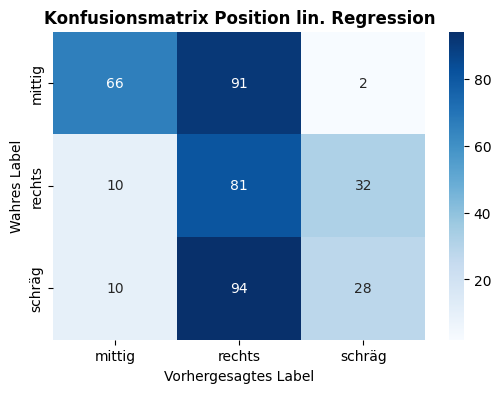

In [16]:
#Konfusionsmatrix der Position
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val_labbeled['Position'], y_lin_pred[:,0])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['mittig', 'rechts', 'schräg'], columns=['mittig', 'rechts', 'schräg'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Position lin. Regression' , fontsize=12, fontweight='bold')
plt.show()

In [17]:
#Metriken der Position
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Position'])
y_pred_numeric = label_encoder.transform(y_lin_pred[:,0])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))

report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      mittig       0.77      0.42      0.54       159
      rechts       0.30      0.66      0.42       123
     schraeg       0.45      0.21      0.29       132

    accuracy                           0.42       414
   macro avg       0.51      0.43      0.41       414
weighted avg       0.53      0.42      0.42       414



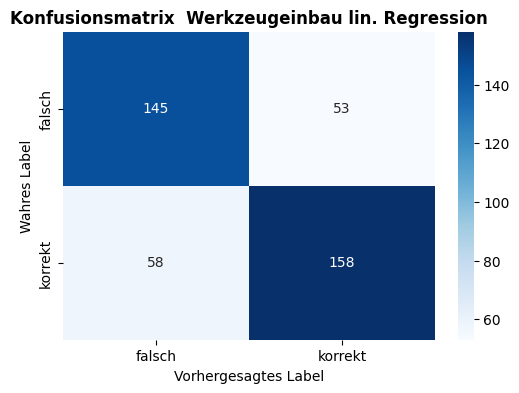

In [18]:
#Konfusionsmatrix des Werkzeugeinbaues
conf_matrix = confusion_matrix(y_val_labbeled['Werkzeug_Einbau'], y_lin_pred[:,1])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['falsch', 'korrekt'], columns=['falsch', 'korrekt'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix  Werkzeugeinbau lin. Regression', fontsize=12, fontweight='bold')
plt.show()

In [19]:
#Metriken des Werkzeugeinbaues
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Werkzeug_Einbau'])
y_pred_numeric = label_encoder.transform(y_lin_pred[:,1])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))

report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      falsch       0.71      0.73      0.72       198
     korrekt       0.75      0.73      0.74       216

    accuracy                           0.73       414
   macro avg       0.73      0.73      0.73       414
weighted avg       0.73      0.73      0.73       414



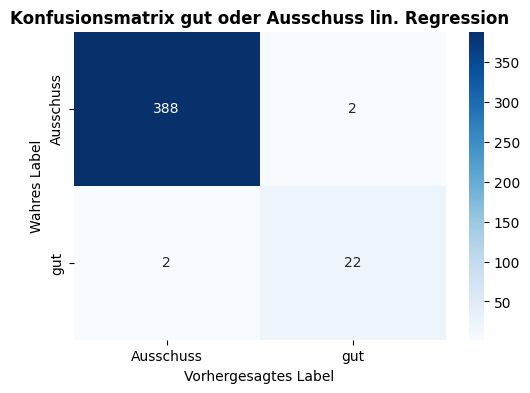

In [20]:
#Konfusionsmatrix ob Ausschuss oder gut
conf_matrix = confusion_matrix(y_val_labbeled['Good_or_bad'], y_lin_pred[:,2])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Ausschuss', 'gut'], columns=['Ausschuss', 'gut'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix gut oder Ausschuss lin. Regression', fontsize=12, fontweight='bold')
plt.show()

In [21]:
#Metriken ob Ausschuss oder gut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Good_or_bad'])
y_pred_numeric = label_encoder.transform(y_lin_pred[:,2])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))

report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         bad       0.99      0.99      0.99       390
        good       0.92      0.92      0.92        24

    accuracy                           0.99       414
   macro avg       0.96      0.96      0.96       414
weighted avg       0.99      0.99      0.99       414



# Random Foerest

In [22]:
y_train_labbeled=y_train.copy()
#y_train_labbeled=y_train_labbeled.astype(str)

y_train_labbeled['Position'][y_train_labbeled['Position'] == 0] = 'schräg'
y_train_labbeled['Position'][y_train_labbeled['Position'] == 50]  = 'rechts'
y_train_labbeled['Position'][y_train_labbeled['Position'] == 100]  = 'mittig'

y_train_labbeled['Werkzeug_Einbau'][y_train_labbeled['Werkzeug_Einbau'] == 0] = 'korrekt'
y_train_labbeled['Werkzeug_Einbau'][y_train_labbeled['Werkzeug_Einbau'] == 100]  = 'falsch'

y_train_labbeled['Good_or_bad'][y_train_labbeled['Good_or_bad'] == 0] = 'bad'
y_train_labbeled['Good_or_bad'][y_train_labbeled['Good_or_bad'] == 100]  = 'good'
y_train_labbeled

,Position,Werkzeug_Einbau,Good_or_bad
681,mittig,korrekt,good
910,schräg,korrekt,bad
938,rechts,korrekt,bad
944,mittig,korrekt,bad
893,mittig,falsch,bad
...,...,...,...
1096,mittig,falsch,bad
1131,rechts,korrekt,bad
1295,schräg,falsch,bad
861,rechts,falsch,bad


In [23]:
#training unoptemierter classifikator
unop_rfreg_scaled = RandomForestRegressor(min_samples_leaf=1,max_depth=84,min_samples_split=2, n_estimators= 50)
unop_rfreg_scaled.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=84, n_estimators=50)

In [24]:
#Hyperparamter bekommen
params = unop_rfreg_scaled.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 84, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [25]:
#def. bayessche optemierung
param_space = {
    'n_estimators': (50, 500),
    'max_depth': (1, 100),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 10)
}

from skopt import BayesSearchCV

# Instantiate RandomForestRegressor
unop_rfreg_scaled = RandomForestRegressor()

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=unop_rfreg_scaled,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5
)

# Fit BayesSearchCV
bayes_search.fit(X_train_scaled, y_train)

# Retrieve best parameters
best_params = bayes_search.best_params_

# Use best estimator
best_estimator = bayes_search.best_estimator_

In [26]:
#hyperpoarameter bekommen
params = best_estimator.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 21, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 304, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search through
param_grid = {
    'n_estimators': [100, 200, 300, 350],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80],
    'min_samples_split': [2, 5, 10],  # Adjusted to exclude 1
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create the RandomForestRegressor
rfreg_scaled = RandomForestRegressor()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rfreg_scaled, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

# Get the best model
best_rfreg = grid_search.best_estimator_

# Fit the best model to the data
best_rfreg.fit(X_train_scaled, y_train)

Best parameters found: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestRegressor(max_depth=40, max_features=None)

In [29]:
#speichern
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rfreg_scaled, file)

In [30]:
#löschen
del rfreg_scaled

In [31]:
#laden
import pickle
with open('random_forest_model.pkl', 'rb') as file:
    rfreg_scaled = pickle.load(file)

In [ ]:

feature_importances = best_estimator.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
plt.xlabel('Eigenschaft Wichtigkeit')
plt.ylabel('Eigenschaft')
plt.title('Eigenschaft Wichtigkeit bei der Random Forest Regression', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
#sensivität der Eigenschaften
from sklearn.inspection import permutation_importance
perm_importance_rf = permutation_importance(rfreg_scaled, X_train_scaled, y_train, n_repeats=30, random_state=42)

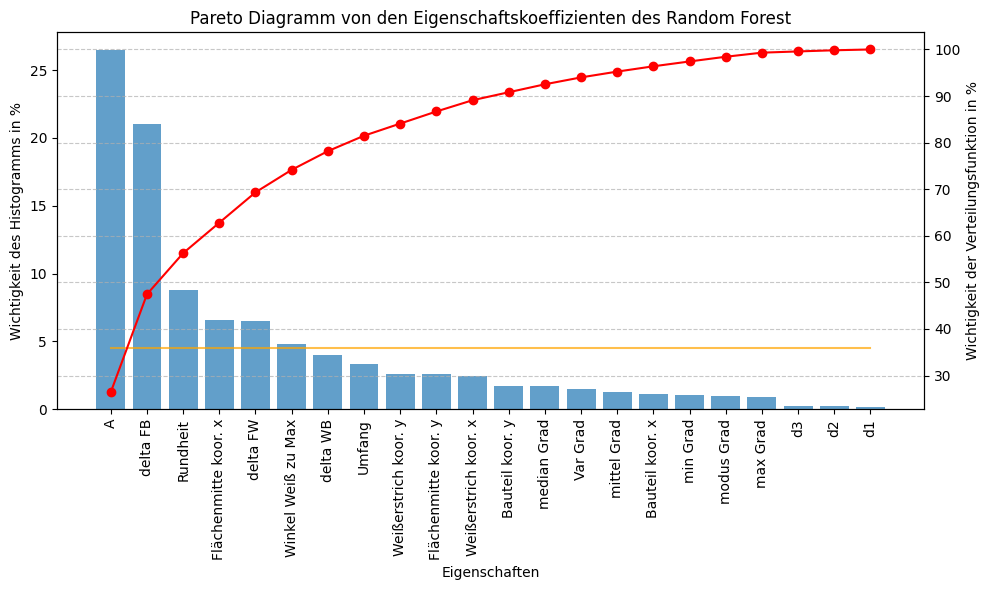

In [ ]:
#pareto diagramm
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_rf.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_rf.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

importance_thresh=[(100/len(sorted_importances))]
index_thresh=[0]
for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
#plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten des Random Forest')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#metriken unoptemiert
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('unopt')
y_pred = unop_rfreg_scaled.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


unopt
Mean Absolute Error: 12.50402576489533
Mean Squared Error: 408.55877616747176
R-squared: 0.8032298965517342


In [ ]:
#metriken optemiert
print('opt')
y_pred = best_estimator.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)




opt
Mean Absolute Error: 12.390660225442835
Mean Squared Error: 391.1022544283415
R-squared: 0.8119050804084164


In [ ]:
#quant to quali
res_random=best_estimator.predict(X_val_scaled)
res_random[res_random[:, 0] <= 25, 0] = 0
res_random[(res_random[:, 0] > 25) & (res_random[:, 0] < 75), 0] = 50
res_random[res_random[:, 0] >= 75, 0] = 100

res_random[res_random[:, 1] < 50, 1] = 0
res_random[res_random[:, 1] >= 50, 1] = 100

res_random[res_random[:, 2] < 50, 2] = 0
res_random[res_random[:, 2] >= 50, 2] = 100

res_random=res_random.astype(str)

res_random[res_random[:, 0] == '0.0', 0] = 'schraeg'
res_random[res_random[:, 0] == '50.0', 0] = 'rechts'
res_random[res_random[:, 0] == '100.0', 0] = 'mittig'

res_random[res_random[:, 1] == '0.0', 1] = 'korrekt'
res_random[res_random[:, 1] == '100.0', 1] = 'falsch'

res_random[res_random[:, 2] == '0.0', 2] = 'bad'
res_random[res_random[:, 2] == '100.0', 2] = 'good'

y_val_labbeled=y_val.astype(str)
 
y_val_labbeled.loc[y_val_labbeled['Position'] == '0', 'Position']='schraeg'
y_val_labbeled.loc[y_val_labbeled['Position'] == '50', 'Position'] = 'rechts'
y_val_labbeled.loc[y_val_labbeled['Position'] == '100', 'Position'] = 'mittig'

y_val_labbeled.loc[y_val_labbeled['Werkzeug_Einbau'] == '0', 'Werkzeug_Einbau']= 'korrekt'
y_val_labbeled.loc[y_val_labbeled['Werkzeug_Einbau'] == '100', 'Werkzeug_Einbau'] = 'falsch'

y_val_labbeled.loc[y_val_labbeled['Good_or_bad'] == '0', 'Good_or_bad']= 'bad'
y_val_labbeled.loc[y_val_labbeled['Good_or_bad'] == '100', 'Good_or_bad'] = 'good'



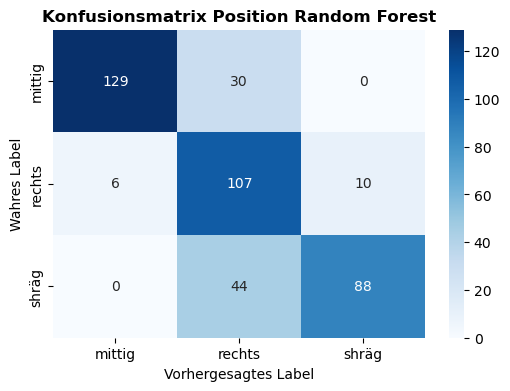

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_labbeled['Position'], res_random[:,0])
# Example confusion matrix dataframe
conf_matrix_df = pd.DataFrame(conf_matrix, index=['mittig', 'rechts', 'shräg'], columns=['mittig', 'rechts', 'shräg'])
# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Position Random Forest',  fontsize=12, fontweight='bold')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Position'])
y_pred_numeric = label_encoder.transform(res_random[:,0])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))


report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      mittig       0.96      0.83      0.89       159
      rechts       0.61      0.89      0.72       123
     schraeg       0.92      0.67      0.78       132

    accuracy                           0.80       414
   macro avg       0.83      0.80      0.80       414
weighted avg       0.84      0.80      0.80       414



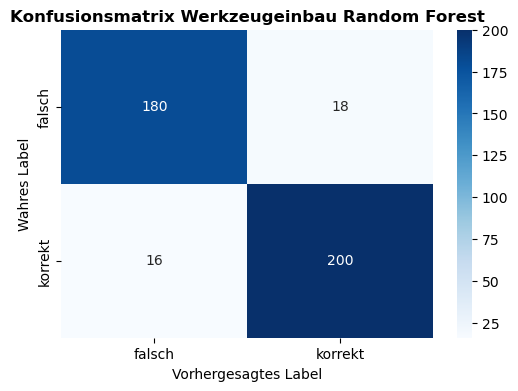

In [ ]:
conf_matrix = confusion_matrix(y_val_labbeled['Werkzeug_Einbau'], res_random[:,1])
# Example confusion matrix dataframe
conf_matrix_df = pd.DataFrame(conf_matrix, index=['falsch', 'korrekt'], columns=['falsch', 'korrekt'])
# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Werkzeugeinbau Random Forest',  fontsize=12, fontweight='bold')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Werkzeug_Einbau'])
y_pred_numeric = label_encoder.transform(res_random[:,1])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))


report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)



print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      falsch       0.92      0.91      0.91       198
     korrekt       0.92      0.93      0.92       216

    accuracy                           0.92       414
   macro avg       0.92      0.92      0.92       414
weighted avg       0.92      0.92      0.92       414



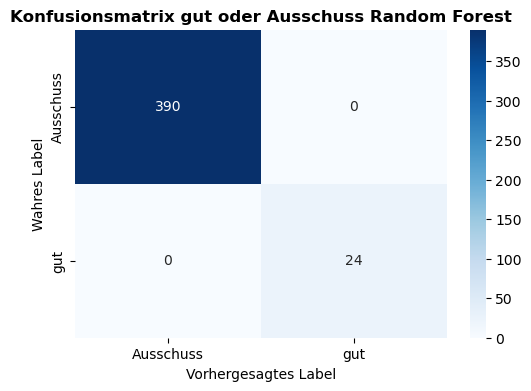

In [ ]:
conf_matrix = confusion_matrix(y_val_labbeled['Good_or_bad'], res_random[:,2])
# Example confusion matrix dataframe
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Ausschuss', 'gut'], columns=['Ausschuss', 'gut'])
# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix gut oder Ausschuss Random Forest',  fontsize=12, fontweight='bold')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
label_encoder = LabelEncoder()

y_true_numeric = label_encoder.fit_transform(y_val_labbeled['Good_or_bad'])
y_pred_numeric = label_encoder.transform(res_random[:,2])
y_pred_labels = label_encoder.inverse_transform(y_lin_pred.argmax(axis=1))


report = classification_report(y_true_numeric, y_pred_numeric, target_names=label_encoder.classes_)



print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       390
        good       1.00      1.00      1.00        24

    accuracy                           1.00       414
   macro avg       1.00      1.00      1.00       414
weighted avg       1.00      1.00      1.00       414



# SVM

In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
labbeld_y_train=y_train.copy()
labbeld_y_val=y_val.copy()

labbeld_y_train.loc[labbeld_y_train['Position'] == 0, 'Position'] = 'schräg'
labbeld_y_train.loc[labbeld_y_train['Position'] == 50, 'Position'] = 'rechts'
labbeld_y_train.loc[labbeld_y_train['Position'] == 100, 'Position'] = 'mittig'

labbeld_y_train.loc[labbeld_y_train['Werkzeug_Einbau'] == 0, 'Werkzeug_Einbau'] = 'korrekt'
labbeld_y_train.loc[labbeld_y_train['Werkzeug_Einbau'] == 100, 'Werkzeug_Einbau'] = 'falsch'

labbeld_y_train.loc[labbeld_y_train['Good_or_bad'] == 0, 'Good_or_bad'] = 'Ausschuss'
labbeld_y_train.loc[labbeld_y_train['Good_or_bad'] == 100, 'Good_or_bad'] = 'gut'

labbeld_y_val.loc[labbeld_y_val['Position'] == 0, 'Position'] = 'schräg'
labbeld_y_val.loc[labbeld_y_val['Position'] == 50, 'Position'] = 'rechts'
labbeld_y_val.loc[labbeld_y_val['Position'] == 100, 'Position'] = 'mittig'

labbeld_y_val.loc[labbeld_y_val['Werkzeug_Einbau'] == 0, 'Werkzeug_Einbau'] = 'korrekt'
labbeld_y_val.loc[labbeld_y_val['Werkzeug_Einbau'] == 100, 'Werkzeug_Einbau'] = 'falsch'

labbeld_y_val.loc[labbeld_y_val['Good_or_bad'] == 0, 'Good_or_bad'] = 'Ausschuss'
labbeld_y_val.loc[labbeld_y_val['Good_or_bad'] == 100, 'Good_or_bad'] = 'gut'

pos_label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded_pos = pos_label_encoder.fit_transform(labbeld_y_train['Position'])

werk_label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded_werk = werk_label_encoder.fit_transform(labbeld_y_train['Werkzeug_Einbau'])

gob_label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded_gob = gob_label_encoder.fit_transform(labbeld_y_train['Good_or_bad'])

labbeld_y_train

,Position,Werkzeug_Einbau,Good_or_bad
681,mittig,korrekt,gut
910,schräg,korrekt,Ausschuss
938,rechts,korrekt,Ausschuss
944,mittig,korrekt,Ausschuss
893,mittig,falsch,Ausschuss
...,...,...,...
1096,mittig,falsch,Ausschuss
1131,rechts,korrekt,Ausschuss
1295,schräg,falsch,Ausschuss
861,rechts,falsch,Ausschuss


In [ ]:
# Train Support Vector Machine
svm_pos = SVC(kernel='rbf', C=1000000.0, gamma=0.235109528887288, random_state=42)
svm_pos.fit(X_train_scaled, y_train_encoded_pos)


SVC(C=1000000.0, gamma=0.235109528887288, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
#from sklearn.model_selection import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from skopt.space import Real, Categorical
import numpy as np
from skopt import BayesSearchCV


# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded = label_encoder.fit_transform(labbeld_y_train['Position'])

# Define the search space for SVM hyperparameters
param_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),        # Regularization parameter
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),    # Kernel coefficient for 'rbf'
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid'])  # Kernel type
}

# Instantiate SVM classifier
svm_pos = SVC()

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=svm_pos,
    search_spaces=param_space,
    n_iter=20,  # Reduced number of iterations
    cv=5,
    n_jobs=-1  # Parallelize the search
)

# Fit BayesSearchCV
bayes_search.fit(X_train_scaled, y_train_encoded)

# Retrieve best parameters
best_params = bayes_search.best_params_

# Use best estimator
svm_pos = bayes_search.best_estimator_



In [ ]:
#beste model als class und hyperparameter
best_score = bayes_search.best_score_
print(best_params)
print("Best Score:", best_score)

OrderedDict([('C', 1000000.0), ('gamma', 0.235109528887288), ('kernel', 'rbf')])
Best Score: 0.8859078151986184


In [ ]:

label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded = label_encoder.fit_transform(labbeld_y_train['Werkzeug_Einbau'])

# Define the search space for SVM hyperparameters
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),        # Regularization parameter
    'gamma': (1e-6, 1e+1, 'log-uniform'),    # Kernel coefficient for 'rbf'
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

# Instantiate SVM classifier
svm_werk = SVC()

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=svm_pos,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,
    n_jobs=-1
)

# Fit BayesSearchCV
bayes_search.fit(X_train_scaled, y_train_encoded)

# Retrieve best parameters
best_params = bayes_search.best_params_

# Use best estimator
svm_werk = bayes_search.best_estimator_
print(best_params)

OrderedDict([('C', 1000000.0), ('gamma', 0.235109528887288), ('kernel', 'rbf')])


In [ ]:
best_score = bayes_search.best_score_

print("Best Score:", best_score)

Best Score: 0.8859078151986184


In [ ]:
label_encoder = LabelEncoder()

# Encode the string class labels in y_train
y_train_encoded = label_encoder.fit_transform(labbeld_y_train['Good_or_bad'])

# Define the search space for SVM hyperparameters
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),        # Regularization parameter
    'gamma': (1e-6, 1e+1, 'log-uniform'),    # Kernel coefficient for 'rbf'
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

# Instantiate SVM classifier
svm_good_or_bad = SVC()

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=svm_pos,
    search_spaces=param_space,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,
    n_jobs=-1
)

# Fit BayesSearchCV
bayes_search.fit(X_train_scaled, y_train_encoded)

# Retrieve best parameters
best_params = bayes_search.best_params_

# Use best estimator
svm_good_or_bad = bayes_search.best_estimator_
print(best_params)

C:\Users\nikla\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 10.0, 'linear'] before, using random point [37.02406275135828, 0.8990134402389667, 'linear']
  warnings.warn(
C:\Users\nikla\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 10.0, 'linear'] before, using random point [6.478253036225411e-06, 8.960724628460124e-05, 'sigmoid']
  warnings.warn(
C:\Users\nikla\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 10.0, 'linear'] before, using random point [1.440732672379684e-06, 1.9044101488288452, 'linear']
  warnings.warn(
C:\Users\nikla\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 10.0, 

OrderedDict([('C', 0.2689557242839162), ('gamma', 10.0), ('kernel', 'linear')])


In [ ]:

svm_werk = SVC(kernel='rbf', C=1000000, gamma=0.235109528887288, random_state=42)
svm_werk.fit(X_train_scaled, y_train_encoded_werk)


SVC(C=1000000, gamma=0.235109528887288, random_state=42)

In [ ]:

svm_good_or_bad = SVC(kernel='linear', C=0.2689557242839162, gamma=10, random_state=42)
svm_good_or_bad.fit(X_train_scaled, y_train_encoded_gob)


SVC(C=0.2689557242839162, gamma=10, kernel='linear', random_state=42)

In [ ]:
import pickle
with open('svm_pos_model.pkl', 'wb') as file:
    pickle.dump(svm_pos, file)

with open('svm_werk_model.pkl', 'wb') as file:
    pickle.dump(svm_werk, file)

with open('svm_good_or_bad_model.pkl', 'wb') as file:
    pickle.dump(svm_good_or_bad, file)

In [ ]:
import pickle
with open('svm_pos_model.pkl', 'rb') as file:
    svm_pos = pickle.load(file)

with open('svm_werk_model.pkl', 'rb') as file:
    svm_werk = pickle.load(file)

with open('svm_good_or_bad_model.pkl', 'rb') as file:
    svm_good_or_bad = pickle.load(file)

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance_pos = permutation_importance(svm_pos, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)


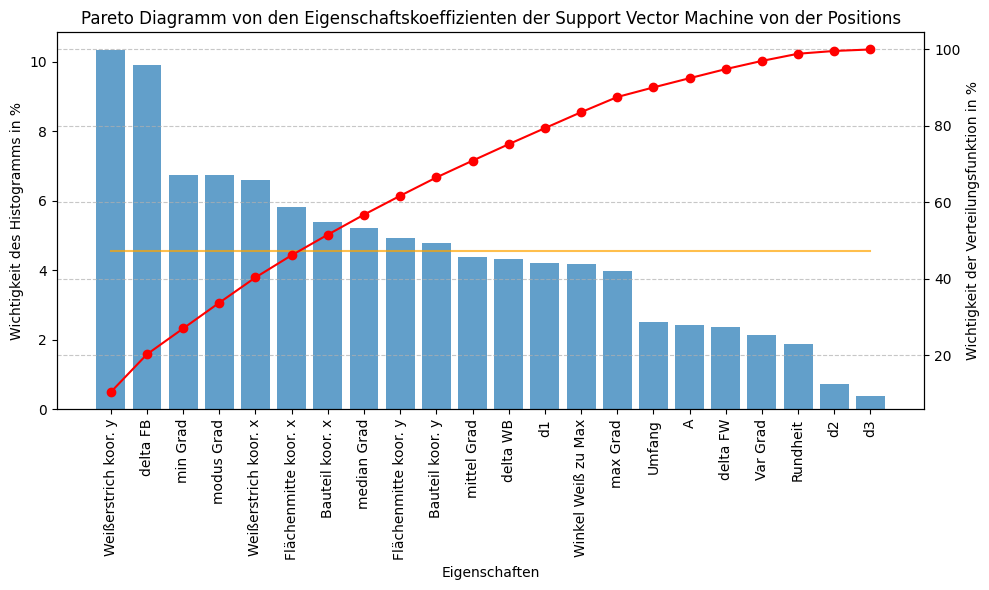

In [ ]:
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_pos.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_pos.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

importance_thresh=[(100/len(sorted_importances))]
index_thresh=[0]
for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)


# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
#plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der Support Vector Machine von der Positions')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
(sorted_importances/np.sum(sorted_importances))*100

array([10.33519553,  9.89944134,  6.74860335,  6.74860335,  6.60335196,
        5.82122905,  5.38547486,  5.22905028,  4.93854749,  4.79329609,
        4.39106145,  4.31284916,  4.20111732,  4.16759777,  3.97765363,
        2.51396648,  2.41340782,  2.37988827,  2.1452514 ,  1.87709497,
        0.72625698,  0.39106145])

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance_werk = permutation_importance(svm_werk, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)


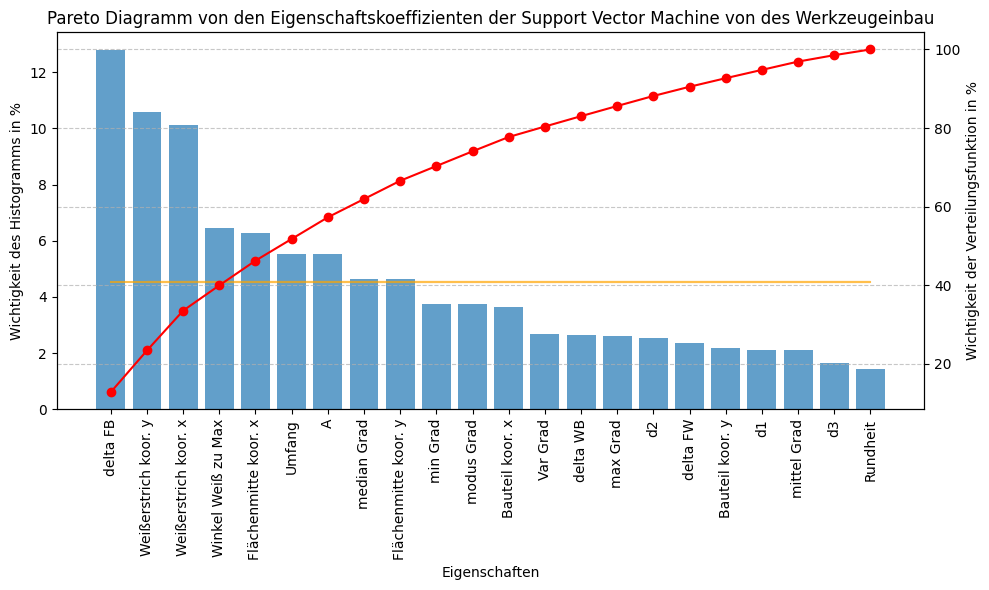

In [ ]:
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_werk.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_werk.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der Support Vector Machine von des Werkzeugeinbau')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance_werk = permutation_importance(svm_good_or_bad, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)

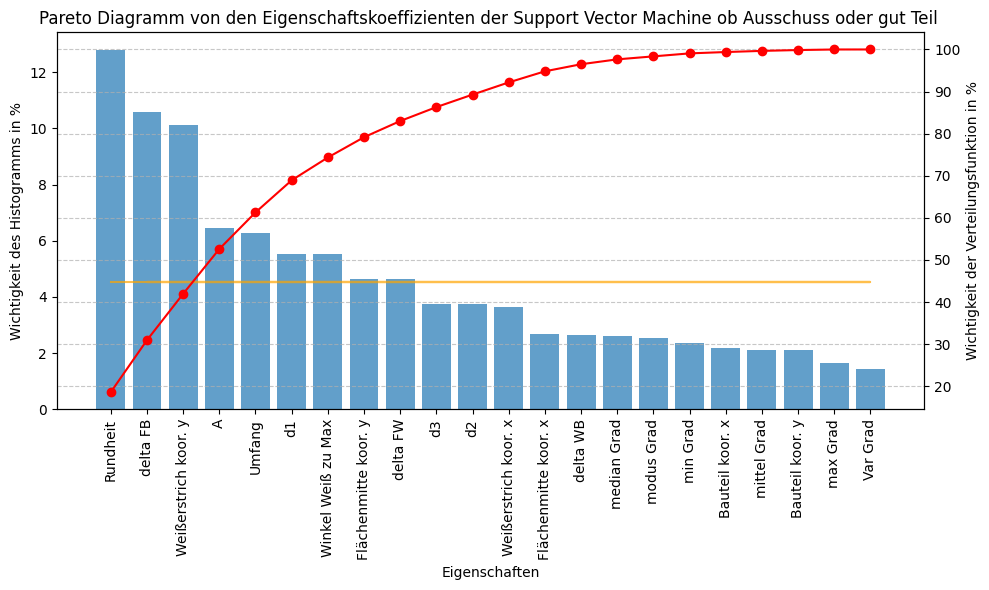

In [ ]:
feature_names=X_train_scaled.columns

# Get feature coefficients from the trained SVM model
feature_coefficients = svm_good_or_bad.coef_[0]

# Calculate the absolute values of the coefficients
abs_feature_coefficients = np.abs(feature_coefficients)

for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Sort the coefficients and their indices in descending order
sorted_indices = np.argsort(abs_feature_coefficients)[::-1]
sorted_coefficients = abs_feature_coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_coefficients)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_coefficients)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der Support Vector Machine ob Ausschuss oder gut Teil ')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Predict on the test set
pred_y_svm_pos= svm_pos.predict(X_val_scaled)
pred_y_svm_werk = svm_werk.predict(X_val_scaled)
pred_y_svm_good_or_bad = svm_good_or_bad.predict(X_val_scaled)


In [ ]:

# Calculate accuracy

pos_accuracy = accuracy_score(labbeld_y_val['Position'], pos_label_encoder.inverse_transform(pred_y_svm_pos))
werk_accuracy = accuracy_score(labbeld_y_val['Werkzeug_Einbau'], werk_label_encoder.inverse_transform(pred_y_svm_werk))
bog_accuracy = accuracy_score(labbeld_y_val['Good_or_bad'], gob_label_encoder.inverse_transform(pred_y_svm_good_or_bad))
print("Accuracy Pos:", pos_accuracy)
print("Accuracy werk:", werk_accuracy)
print("Accuracy bog:", bog_accuracy)


Accuracy Pos: 0.30676328502415456
Accuracy werk: 0.09420289855072464
Accuracy bog: 0.9951690821256038


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
y_true_numeric = pos_label_encoder.fit_transform(labbeld_y_val['Position'])

report = classification_report(y_true_numeric, pred_y_svm_pos, target_names=pos_label_encoder.classes_)



print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      mittig       0.89      0.90      0.89       159
      rechts       0.91      0.85      0.88       123
      schräg       0.83      0.86      0.84       132

    accuracy                           0.87       414
   macro avg       0.88      0.87      0.87       414
weighted avg       0.88      0.87      0.87       414



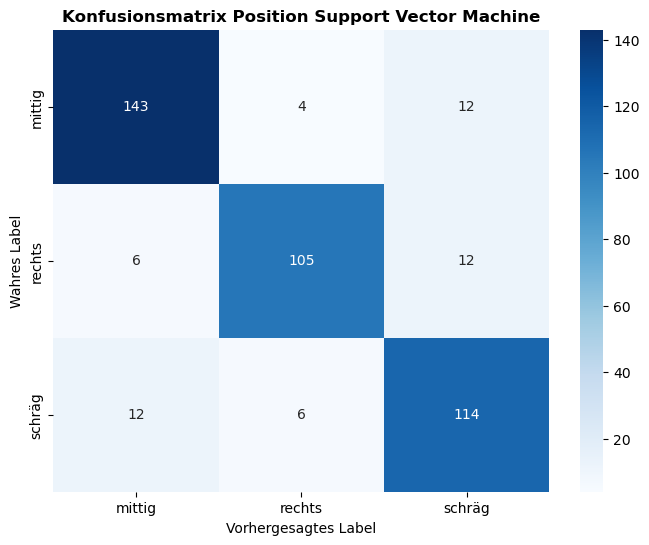

In [ ]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
series1 = pd.Series(pos_label_encoder.inverse_transform(pred_y_svm_pos)).reset_index(drop=True)
series2 = labbeld_y_val['Position'].reset_index(drop=True)

label=('shraeg', 'rechts', 'mittig')
cm = confusion_matrix(series2, series1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=pos_label_encoder.classes_, yticklabels=pos_label_encoder.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Position Support Vector Machine',  fontsize=12, fontweight='bold')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
y_true_numeric = werk_label_encoder.fit_transform(labbeld_y_val['Werkzeug_Einbau'])

report = classification_report(y_true_numeric, pred_y_svm_werk, target_names=werk_label_encoder.classes_)



print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      falsch       0.93      0.89      0.91       198
     korrekt       0.90      0.94      0.92       216

    accuracy                           0.91       414
   macro avg       0.91      0.91      0.91       414
weighted avg       0.91      0.91      0.91       414



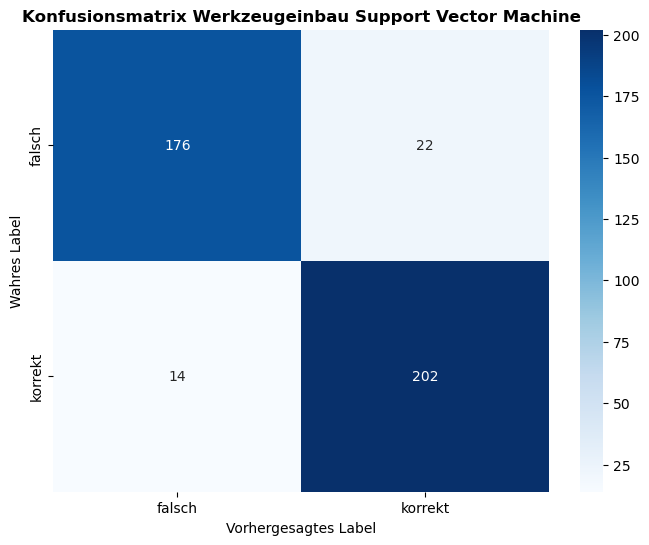

In [ ]:
cm = confusion_matrix(labbeld_y_val['Werkzeug_Einbau'], werk_label_encoder.inverse_transform(pred_y_svm_werk))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=werk_label_encoder.classes_, yticklabels=werk_label_encoder.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Werkzeugeinbau Support Vector Machine',  fontsize=12, fontweight='bold')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
y_true_numeric = gob_label_encoder.fit_transform(labbeld_y_val['Good_or_bad'])

report = classification_report(y_true_numeric, pred_y_svm_good_or_bad, target_names=gob_label_encoder.classes_)



print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         bad       0.99      0.99      0.99       390
        good       0.92      0.92      0.92        24

    accuracy                           0.99       414
   macro avg       0.96      0.96      0.96       414
weighted avg       0.99      0.99      0.99       414



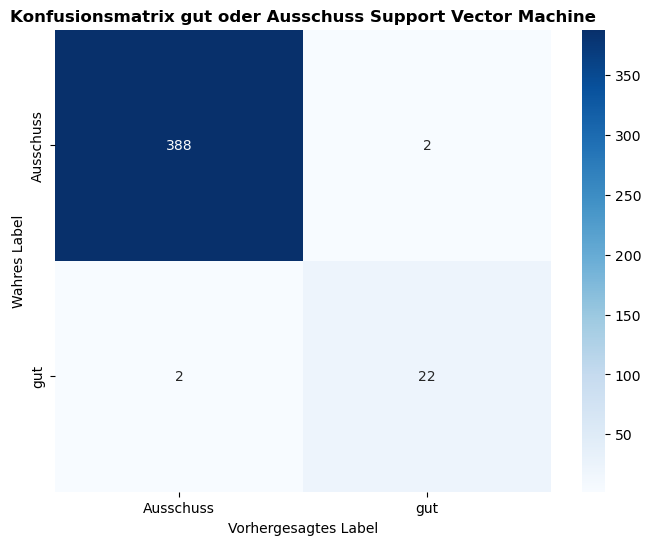

In [ ]:
cm = confusion_matrix(labbeld_y_val['Good_or_bad'], gob_label_encoder.inverse_transform(pred_y_svm_good_or_bad))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=gob_label_encoder.classes_, yticklabels=gob_label_encoder.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix gut oder Ausschuss Support Vector Machine',  fontsize=12, fontweight='bold')
plt.show()

# K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier
pos_knn = KNeighborsClassifier(n_neighbors=5)
werk_knn = KNeighborsClassifier(n_neighbors=5)
bog_knn =KNeighborsClassifier(n_neighbors=5)
# Train the classifier

pos_knn.fit(X_train_scaled, labbeld_y_train['Position'])
werk_knn.fit(X_train_scaled, labbeld_y_train['Werkzeug_Einbau'])
bog_knn.fit(X_train_scaled, labbeld_y_train['Good_or_bad'])

KNeighborsClassifier()

In [ ]:
#optemiere def.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
label_encoder_gob = LabelEncoder()
label_encoder_werk = LabelEncoder()
label_encoder_pos = LabelEncoder()

pos_knn = KNeighborsClassifier()
werk_knn = KNeighborsClassifier()
bog_knn =KNeighborsClassifier()

# Encode the string class labels in y_train
y_train_encoded_pos = label_encoder_pos.fit_transform(labbeld_y_train['Position'])
y_train_encoded_werk = label_encoder_werk.fit_transform(labbeld_y_train['Werkzeug_Einbau'])
y_train_encoded_gob = label_encoder_gob.fit_transform(labbeld_y_train['Good_or_bad'])

# Define the parameter search spaces
param_space = {
    'n_neighbors': (3, 10),
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Perform Bayesian optimization
bayes_search_pos = BayesSearchCV(pos_knn, param_space, cv=5, n_jobs=-1, scoring='f1_weighted')
bayes_search_werk = BayesSearchCV(werk_knn, param_space, cv=5, n_jobs=-1, scoring='f1')
bayes_search_bog = BayesSearchCV(bog_knn, param_space, cv=5, n_jobs=-1, scoring='f1')


In [ ]:
#training clas position
bayes_search_pos.fit(X_train_scaled, y_train_encoded_pos)

c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 6] before, using random point ['euclidean', 6]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 4] before, using random point ['chebyshev', 8]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 6] before, using random point ['chebyshev', 3]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 6] before, using random point ['chebyshev', 3]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera

BayesSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
              scoring='f1_weighted',
              search_spaces={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                             'n_neighbors': (3, 10)})

In [ ]:
#training clas werkzeugeinbau
bayes_search_werk.fit(X_train_scaled, y_train_encoded_werk)

c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5] before, using random point ['chebyshev', 3]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5] before, using random point ['euclidean', 8]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 6] before, using random point ['manhattan', 10]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5] before, using random point ['euclidean', 7]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camer

BayesSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1, scoring='f1',
              search_spaces={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                             'n_neighbors': (3, 10)})

In [ ]:
#training clas bad or good

bayes_search_bog.fit(X_train_scaled, y_train_encoded_gob)

c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 5] before, using random point ['chebyshev', 3]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 3] before, using random point ['chebyshev', 7]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 5] before, using random point ['chebyshev', 7]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera_program\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['chebyshev', 5] before, using random point ['chebyshev', 4]
  warnings.warn(
c:\LUH\Master\Masterarbeit\Stereo_camera

BayesSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1, scoring='f1',
              search_spaces={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                             'n_neighbors': (3, 10)})

In [ ]:
# Get the best hyperparameters
best_params_pos = bayes_search_pos.best_params_
best_params_werk = bayes_search_werk.best_params_
best_params_gob = bayes_search_bog.best_params_
print(best_params_pos)
print(best_params_werk)
print(best_params_gob)

OrderedDict([('metric', 'manhattan'), ('n_neighbors', 6)])
OrderedDict([('metric', 'manhattan'), ('n_neighbors', 5)])
OrderedDict([('metric', 'chebyshev'), ('n_neighbors', 5)])


In [ ]:
#def best to class
pos_knn = bayes_search_pos.best_estimator_
werk_knn = bayes_search_werk.best_estimator_
bog_knn = bayes_search_bog.best_estimator_


In [ ]:
#geht sensibilität von classificator
from sklearn.inspection import permutation_importance
perm_importance_pos = permutation_importance(pos_knn, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)
perm_importance_werk = permutation_importance(werk_knn, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)
perm_importance_bog = permutation_importance(bog_knn, X_train_scaled, y_train_encoded_gob, n_repeats=30, random_state=42)

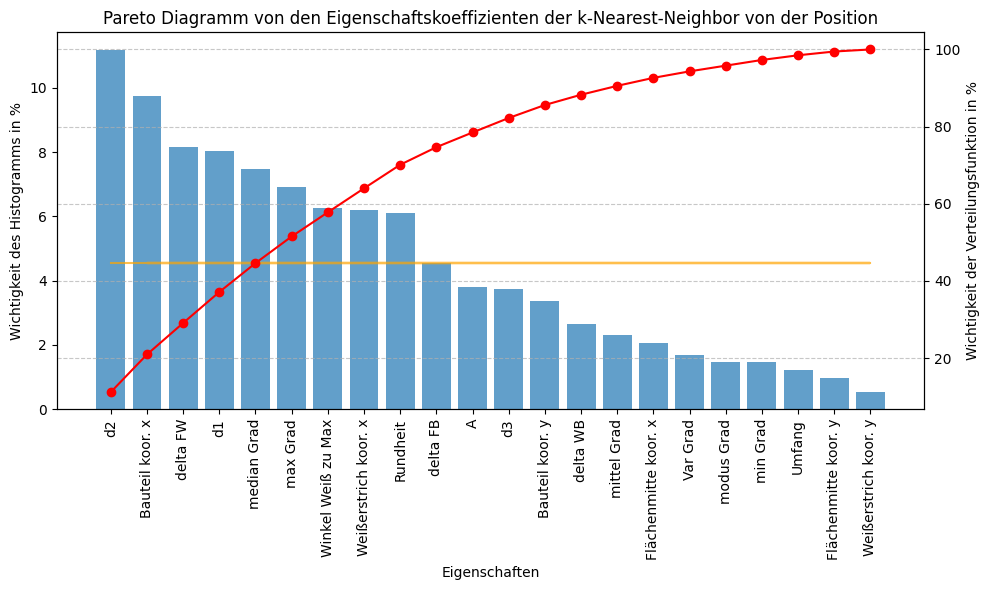

array([11.17351463,  9.75465563,  8.15843926,  8.04020101,  7.47856932,
        6.91693763,  6.26662725,  6.20750813,  6.11882944,  4.55217263,
        3.81318356,  3.75406444,  3.36979013,  2.66036063,  2.30564588,
        2.06916938,  1.68489506,  1.47797813,  1.47797813,  1.21194206,
        0.97546556,  0.53207213])

In [ ]:
#Paretodiagramm
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_pos.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_pos.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der k-Nearest-Neighbor von der Position')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
(sorted_importances/np.sum(sorted_importances))*100

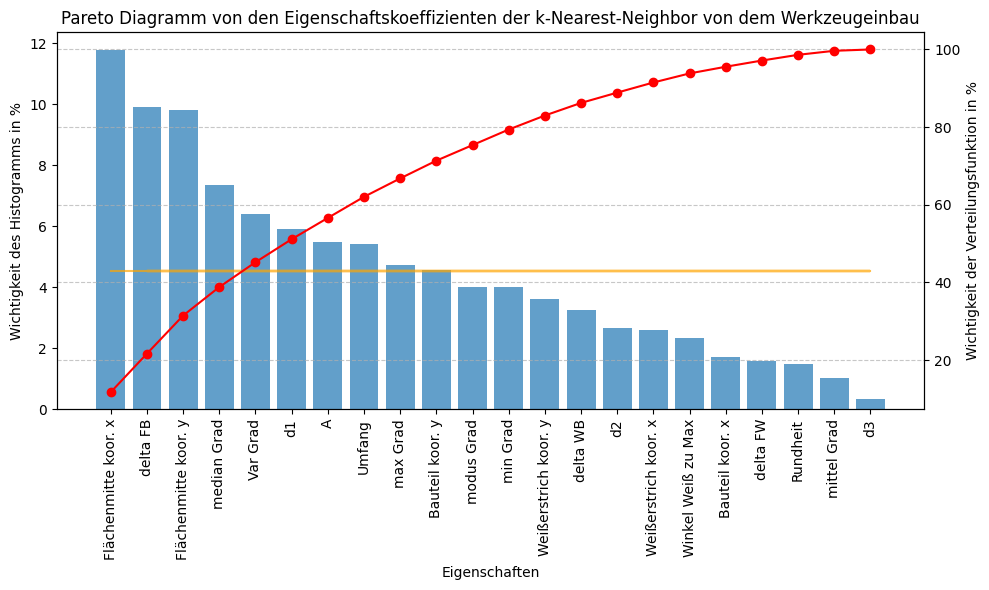

array([11.77193414,  9.90415335,  9.8058491 ,  7.34824281,  6.38977636,
        5.92283116,  5.48046203,  5.4313099 ,  4.74318014,  4.5711477 ,
        4.00589826,  4.00589826,  3.61268125,  3.2440403 ,  2.65421479,
        2.60506267,  2.33472598,  1.7203244 ,  1.59744409,  1.47456377,
        1.03219464,  0.34406488])

In [ ]:
#Paretodiagramm
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_werk.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_werk.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der k-Nearest-Neighbor von dem Werkzeugeinbau')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
(sorted_importances/np.sum(sorted_importances))*100

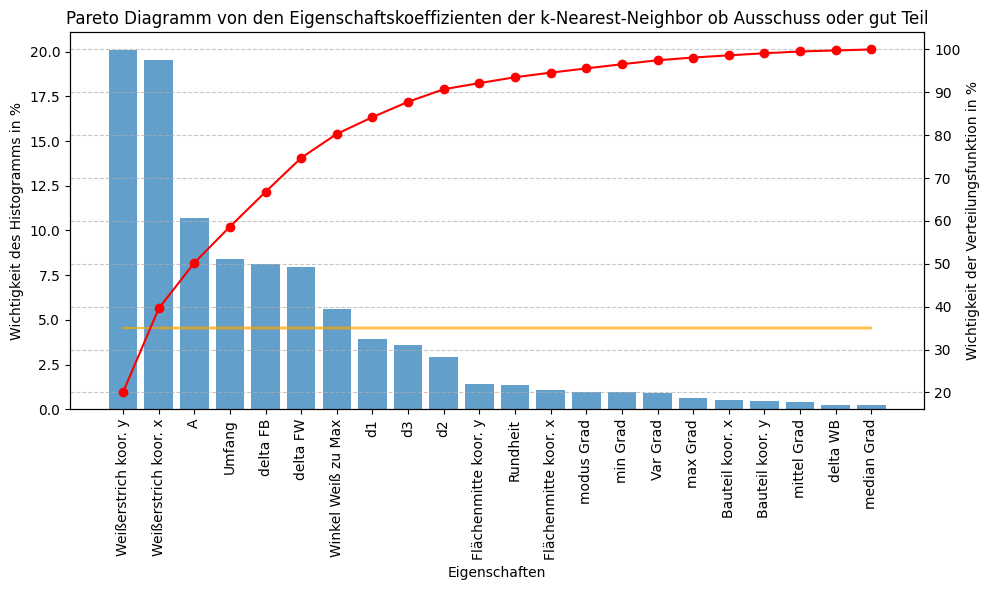

array([20.07705479, 19.50627854, 10.67351598,  8.41894977,  8.11929224,
        7.93378995,  5.5793379 ,  3.90981735,  3.581621  ,  2.92522831,
        1.42694064,  1.36986301,  1.07020548,  0.98458904,  0.98458904,
        0.91324201,  0.64212329,  0.51369863,  0.48515982,  0.41381279,
        0.24257991,  0.2283105 ])

In [ ]:
#Paretodiagramm
feature_names=X_train_scaled.columns

# Get sorted indices of features based on importance
sorted_indices = np.argsort(np.abs(perm_importance_bog.importances_mean))[::-1]
sorted_importances = np.abs(perm_importance_bog.importances_mean[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for i in range(len(sorted_importances)-1):
    importance_thresh.append((100/len(sorted_importances)))
    index_thresh.append(i+1)

# Calculate the cumulative sum of coefficients
cumulative_sum = np.cumsum(sorted_importances)

# Calculate the total sum of coefficients
total_sum = np.sum(sorted_importances)

# Calculate the percentage of total sum for each coefficient
percentage_contribution = (cumulative_sum / total_sum) * 100

# Plot the Pareto diagram with log scale for y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(sorted_importances)), (sorted_importances/np.sum(sorted_importances))*100, alpha=0.7)
ax1.plot( index_thresh, importance_thresh,alpha=0.7, c='orange' )
ax1.set_xlabel('Eigenschaften')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90, label='Histogramm')
ax1.set_ylabel('Wichtigkeit des Histogramms in %')

ax2 = ax1.twinx()
ax2.set_ylabel('Wichtigkeit der Verteilungsfunktion in %')
ax2.plot(range(len(sorted_importances)), percentage_contribution, color='red', marker='o', label='Verteilungsfunktion')
#plt.yscale('log')  # Set log scale for y-axis
plt.title('Pareto Diagramm von den Eigenschaftskoeffizienten der k-Nearest-Neighbor ob Ausschuss oder gut Teil')



plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
(sorted_importances/np.sum(sorted_importances))*100

In [ ]:
#predict
pred_y_knn_pos= pos_knn.predict(X_val_scaled)
pred_y_knn_werk = werk_knn.predict(X_val_scaled)
pred_y_knn_good_or_bad = bog_knn.predict(X_val_scaled)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
#metriken

y_true_numeric=pos_label_encoder.transform(labbeld_y_val['Position'])

report = classification_report(y_true_numeric, pred_y_knn_pos, target_names=pos_label_encoder.classes_, zero_division=0)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      mittig       0.68      0.81      0.74       159
      rechts       0.66      0.63      0.65       123
      schräg       0.65      0.52      0.58       132

    accuracy                           0.67       414
   macro avg       0.66      0.66      0.66       414
weighted avg       0.66      0.67      0.66       414



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

y_true_numeric=werk_label_encoder.transform(labbeld_y_val['Werkzeug_Einbau'])

report = classification_report(y_true_numeric, pred_y_knn_werk, target_names=werk_label_encoder.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      falsch       0.75      0.76      0.75       198
     korrekt       0.78      0.77      0.77       216

    accuracy                           0.76       414
   macro avg       0.76      0.76      0.76       414
weighted avg       0.76      0.76      0.76       414



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

y_true_numeric=label_encoder_gob.transform(labbeld_y_val['Good_or_bad'])

report = classification_report(y_true_numeric, pred_y_knn_good_or_bad, target_names=label_encoder_gob.classes_)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   Ausschuss       0.99      0.99      0.99       390
         gut       0.92      0.92      0.92        24

    accuracy                           0.99       414
   macro avg       0.96      0.96      0.96       414
weighted avg       0.99      0.99      0.99       414



In [ ]:
#speichern
with open('pos_knn_model.pkl', 'wb') as file:
    pickle.dump(pos_knn, file)

with open('werk_knn_model.pkl', 'wb') as file:
    pickle.dump(werk_knn, file)

with open('bog_knn_model.pkl', 'wb') as file:
    pickle.dump(bog_knn, file)

In [ ]:
#laden
with open('pos_knn_model.pkl', 'rb') as file:
    pos_knn = pickle.load(file)

with open('werk_knn_model.pkl', 'rb') as file:
    werk_knn = pickle.load(file)

with open('bog_knn_model.pkl', 'rb') as file:
    bog_knn = pickle.load(file)

In [ ]:

# Make predictions on the test set
pred_y_knn_pos = pos_knn.predict(X_val_scaled)
pred_y_knn_werk = werk_knn.predict(X_val_scaled)
pred_y_knn_bog = bog_knn.predict(X_val_scaled)



In [ ]:
# Calculate accuracy
pos_accuracy = accuracy_score(labbeld_y_val['Position'], label_encoder_pos.inverse_transform(pred_y_knn_pos))
werk_accuracy = accuracy_score(labbeld_y_val['Werkzeug_Einbau'], label_encoder_werk.inverse_transform(pred_y_knn_werk))
bog_accuracy = accuracy_score(labbeld_y_val['Good_or_bad'], label_encoder_gob.inverse_transform(pred_y_knn_bog))
print("Accuracy Pos:", pos_accuracy)
print("Accuracy werk:", werk_accuracy)
print("Accuracy bog:", bog_accuracy)

Accuracy Pos: 0.6666666666666666
Accuracy werk: 0.7632850241545893
Accuracy bog: 0.9903381642512077


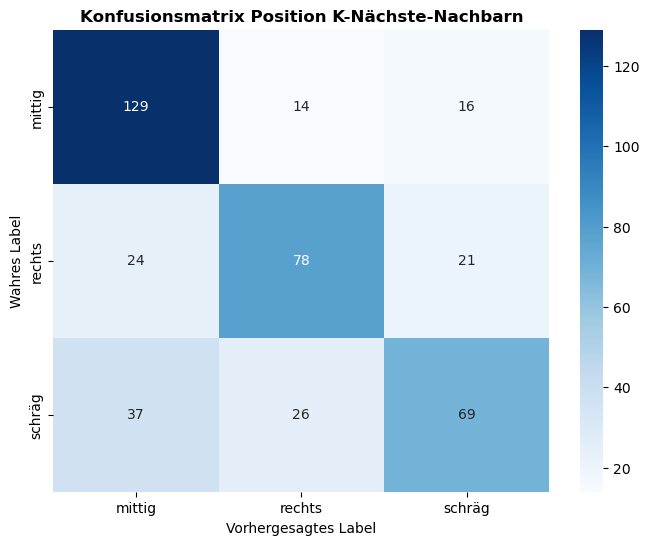

In [ ]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labbeld_y_val['Position'], label_encoder_pos.inverse_transform(pred_y_knn_pos))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder_pos.classes_, yticklabels=label_encoder_pos.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Position K-Nächste-Nachbarn',  fontsize=12, fontweight='bold')
plt.show()

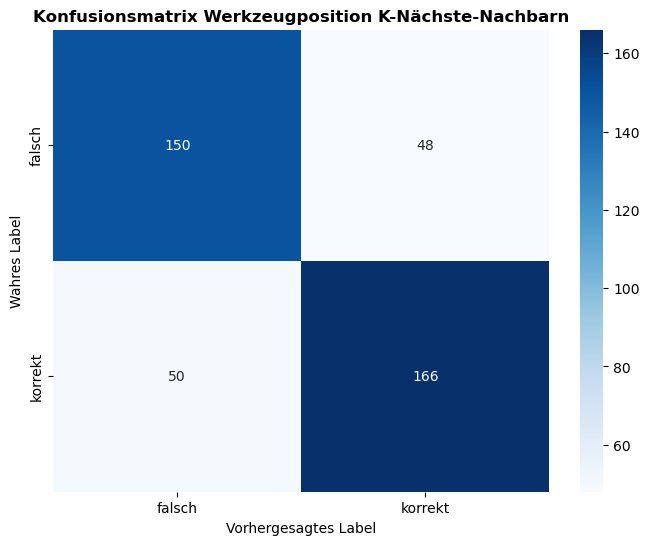

In [ ]:
cm = confusion_matrix(labbeld_y_val['Werkzeug_Einbau'], label_encoder_werk.inverse_transform(pred_y_knn_werk))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder_werk.classes_, yticklabels=label_encoder_werk.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix Werkzeugposition K-Nächste-Nachbarn',  fontsize=12, fontweight='bold')
plt.show()

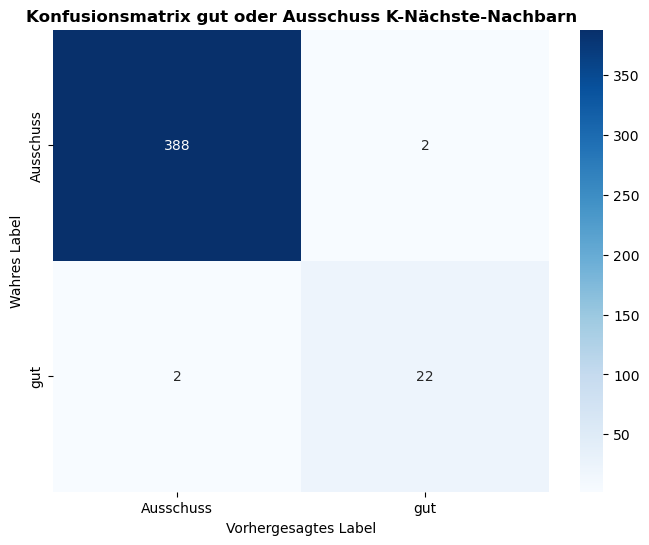

In [ ]:
cm = confusion_matrix(labbeld_y_val['Good_or_bad'], label_encoder_gob.inverse_transform(pred_y_knn_bog))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder_gob.classes_, yticklabels=label_encoder_gob.classes_)
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Wahres Label')
plt.title('Konfusionsmatrix gut oder Ausschuss K-Nächste-Nachbarn',  fontsize=12, fontweight='bold')
plt.show()